In [1]:
# Plotting Features against score
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GATv2Conv, global_mean_pool
print('torch version:',torch.__version__)
print('torch version.cuda:',torch.version.cuda)
print('torch geometric version:',torch_geometric.__version__)
from sparticles_hadhad.rewritten_dataset import EventsDataset
from sparticles_hadhad.rewritten_dataset import DEFAULT_EVENT_SUBSETS
from sparticles_hadhad.rewritten_dataset import EVENT_TABLE
import matplotlib.pyplot as plt
from sparticles_hadhad.transforms import MakeHomogeneous
make_homogeneous_trans = MakeHomogeneous()
from sparticles import plot_event_2d
import os
import errno
import numpy as np
from numpy import pi
import time
from torchmetrics import Accuracy
from tqdm import tqdm # for nice bar
from sklearn.metrics import roc_curve, auc
import pandas as pd
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import json
import yaml

def remove_processed(filename):
    try:
        os.remove(filename)
    except OSError as e: 
        if e.errno != errno.ENOENT: 
            raise

def add_score_from_snapshot(dataset, model, snap_name):
    # Load snapshot and set model to that point
    checkpoint = torch.load(snap_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    scores = []
    # Loop over dataset and apply model
    for elem in dataset:
        output = model(elem.data_norm.float(), elem.edge_index, elem.batch)
        prob = torch.sigmoid(output).squeeze().detach()
        elem.score = prob
        scores.append(elem)
    return scores

MANUAL_SEED = 1234 

class GAT(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, num_classes):
        super(GAT, self).__init__()
        torch.manual_seed(MANUAL_SEED)
        self.conv1 = GATv2Conv(input_channels, hidden_channels)
        self.activation1 = torch.nn.ReLU() 
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels)
        self.activation2 = torch.nn.ReLU() 
        self.conv3 = GATv2Conv(hidden_channels, hidden_channels)
        self.aggregate = global_mean_pool
        self.head = torch.nn.Linear(hidden_channels, num_classes)


    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.activation1(x)
        x = self.conv2(x, edge_index)
        x = self.activation2(x)
        x = self.conv3(x, edge_index)
        x = self.aggregate(x, batch)
        x = self.head(x)
        return x

torch version: 2.2.1+cu121
torch version.cuda: 12.1
torch geometric version: 2.6.1


In [2]:
#Code block for processing the raw data from the h5 file. These are the h5 files that cut events with pT < 20GeV.

LAMBDA_VAL = 100 #100, 240, 300
lambda_values = 100, 240, 300
lambda_signal = (72380, 74169, 65152)

if LAMBDA_VAL in lambda_values:
    index = lambda_values.index(LAMBDA_VAL)
    selected_signal = lambda_signal[index]

sig_no = selected_signal #max lambda100 = 72380, lambda240 = 74169, lambda300 = 65152
ttb_no = 213475 #max = 213475, inclusive max = 48444
vjets_no = 0

if sig_no == ttb_no:
    stats_string = 'balanced_stats'
else:
    stats_string = f'sig_{sig_no}_ttb_{ttb_no}'
    
processed_file = f"/hepstore/{os.environ['USER']}/fcc_hh_data_hadhad_84TeV/processed/events_signal_{sig_no}_ttbar_{ttb_no}_vjets_{vjets_no}.pt"

def remove_processed(filename):
    try:
        os.remove(filename)
    except OSError as e: 
        if e.errno != errno.ENOENT: 
            raise

#remove_processed(processed_file)



# with open('means.yaml' ) as f:
#     mean_list_loaded = yaml.load(f, Loader = yaml.Loader)

# with open('std.yaml' ) as g:
#     std_list_loaded = yaml.load(g, Loader = yaml.Loader)



graphs = EventsDataset(
    root= f'/hepstore/{os.environ["USER"]}/fcc_hh_data_hadhad_84TeV',
    url='https://cernbox.cern.ch/s/SpsIy2kRzVZtwnn/download/',
    delete_raw_archive=False,
    add_edge_index=True,
    event_subsets={'signal': sig_no, 'ttbar': ttb_no, 'vjets': vjets_no}, #For the FCC, only ttbar events are used, but the h5 file for background is saved and taken from the 'singletop' file. 
    transform=MakeHomogeneous(),
    download_type=2,
    signal_filename=f'pwp8_pp_hh_lambda{LAMBDA_VAL}_5f_80TeV_SA_hhbbtata.h5', # Specify the signal filename here
    background_filename='mgp8_pp_tt012j_5f_84TeV_blvblv.h5',
    bb_features = {"m_bb": True, "dEta_bb": False, "dPhi_bb": False, "dR_bb": True},
    tt_features = {"m_tt": True, "dEta_tt": False, "dPhi_tt": False, "dR_tt": True, "dpT_tt": True},
    other_features = {"m_T": True, "C_met": True, "m_HH": True, "dPhi_HH": True},
#    loaded_means = mean_list_loaded, # for the standisation to be the same when applying the kappa_lambda = 1 to the other signal samples.
#    loaded_stds = std_list_loaded
)
  
save_bool = graphs.feature_string()

In [3]:
import torch
import torch.nn.functional as F
import time
from torchmetrics import Accuracy
from tqdm import tqdm # for nice bar
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import time

# 5 fold 
# fold |  A        | B        | C        | D        | E        |
#  1   |  Train    | Train    | Train    | Validate | Test     |
#  2   |  Test     | Train    | Train    | Train    | Validate |
#  3   |  Validate | Test     | Train    | Train    | Train    |
#  4   |  Train    | Validate | Test     | Train    | Train    |
#  4   |  Train    | Train    | Validate | Test     | Train    |


also_graphs = graphs

setA_graphs = also_graphs[0::5] 
setB_graphs = also_graphs[1::5] 
setC_graphs = also_graphs[2::5] 
setD_graphs = also_graphs[3::5]
setE_graphs = also_graphs[4::5]

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = GAT(input_channels=graphs[0].data_norm.shape[1], hidden_channels=50, num_classes=1) #num_classes denotes the output, we have output of dimension 1 in our case.
model.to(device)

def set_shift(all_graphs): 
    all_graphs = all_graphs[-1:] + all_graphs[:-1]
    return all_graphs

sig_weight = ttb_no/sig_no
compute_acc = Accuracy(task='binary')
compute_acc.to(device)

test_losses = []
test_accuracies = []
all_true_labels = []
all_predicted_probs = []
all_signal_probs = []
all_background_probs = []
all_score_graphs = []



def import_snapshot(model, snap_name):
    checkpoint = torch.load(snap_name)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    val_losses = np.array(checkpoint['val_losses'])
    model.eval()

    return model, val_losses

LAST_EPOCH = 99

all_graphs = setA_graphs, setB_graphs, setC_graphs, setD_graphs, setE_graphs

graphs_with_score = []

for fold in range(len(all_graphs)):
    model.to('cpu')
    test_graphs = all_graphs[4] # selects the last value of all splits
    print(f'Applying score to test set fold {fold}...')
    score_graphs = add_score_from_snapshot(test_graphs, model, f"Epochs/fixed_kFolds/CarlFold/84TeV/CarlFold_{fold}_100_epoch_99.pth")
    all_score_graphs = all_score_graphs + score_graphs
    print('Done!')
    all_graphs = set_shift(all_graphs) #shifts the slices by one

Applying score to test set fold 0...
Done!
Applying score to test set fold 1...
Done!
Applying score to test set fold 2...
Done!
Applying score to test set fold 3...
Done!
Applying score to test set fold 4...
Done!


In [41]:
print(len(all_score_graphs))
score_graphs = all_score_graphs
#score_graphs = all_score_graphs[0] + all_score_graphs[1]+ all_score_graphs[2]+ all_score_graphs[3]+ all_score_graphs[4]
print(len(score_graphs))
score_below_0_4 = [g for g in score_graphs if g.score < 0.4]
print(len(score_below_0_4))

285855
285855
203988


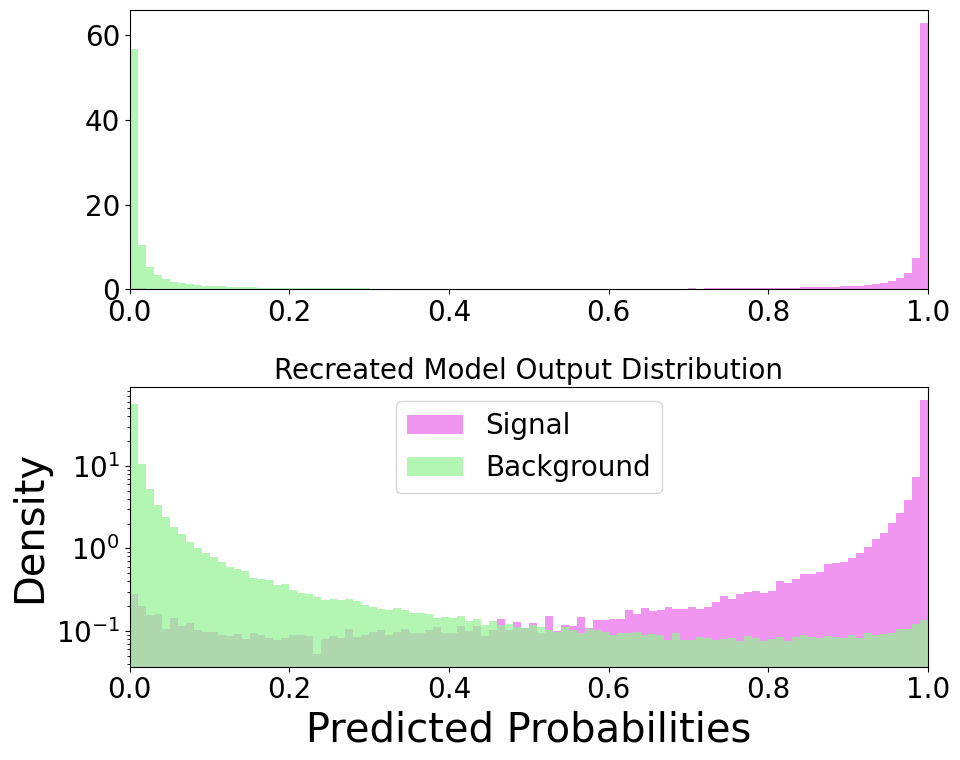

In [42]:
# Checking to see if score was applied correctly...
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.yscale('linear')
sig_score = [s.score for s in score_graphs if s.y == 1]
bkg_score = [s.score for s in score_graphs if s.y == 0]
plt.hist(sig_score, bins=100, color= '#ea6aea', alpha=0.7, density=True, label='Signal')
plt.hist(bkg_score, bins=100, color= '#93f393', alpha=0.7, density=True, label='Background')
plt.xlim(0,1)
plt.subplot(2,1,2)
plt.yscale('log')
plt.hist(sig_score, bins=100, color= '#ea6aea', alpha=0.7, density=True, label='Signal')
plt.hist(bkg_score, bins=100, color= '#93f393', alpha=0.7, density=True, label='Background')
plt.title('Recreated Model Output Distribution')
plt.xlabel('Predicted Probabilities',fontsize="x-large")
plt.ylabel('Density',fontsize="x-large")
plt.xlim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
# Threshold Values

threshold1 = 0.8
threshold2 = 0.8


In [44]:
# sorting jet1 node between signal and background
jet1_greater_sig = [g.x[5] for g in score_graphs if g.y.item() == 1 and g.x.shape == (7,24) and g.score > threshold1]
jet1_lesser_sig = [g.x[5] for g in score_graphs if g.y.item() == 1 and g.x.shape == (7,24) and g.score < threshold2]
jet1_greater_bkg = [g.x[5] for g in score_graphs if g.y.item() == 0 and g.x.shape == (7,24) and g.score > threshold1]
jet1_lesser_bkg = [g.x[5] for g in score_graphs if g.y.item() == 0 and g.x.shape == (7,24) and g.score < threshold2]
# sorting complex node between signal and background
complex_greater_sig = [g.x[-1] for g in score_graphs if g.y.item() == 1 and g.score > threshold1]
complex_lesser_sig = [g.x[-1] for g in score_graphs if g.y.item() == 1 and g.score < threshold2]
complex_greater_bkg = [g.x[-1] for g in score_graphs if g.y.item() == 0 and g.score > threshold1]
complex_lesser_bkg = [g.x[-1] for g in score_graphs if g.y.item() == 0 and g.score < threshold2]

In [50]:
print(len(score_graphs))

print(len(complex_greater_sig)/(72380))
print(len(complex_greater_bkg)/(213475))
print('')
print(len(jet1_greater_sig)/len(complex_greater_sig))

print(len(jet1_greater_sig), len(jet1_lesser_sig))
print(len(jet1_greater_sig)/72380)
print(len(jet1_greater_bkg), len(jet1_lesser_bkg))
print(len(jet1_greater_bkg)/213475)

285855
0.8927880630008289
0.018456493734629348

0.6900959455277004
44594 5754
0.6161094224924012
3005 155920
0.014076589764609439


In [13]:
LEGEND_SIZE = 8
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

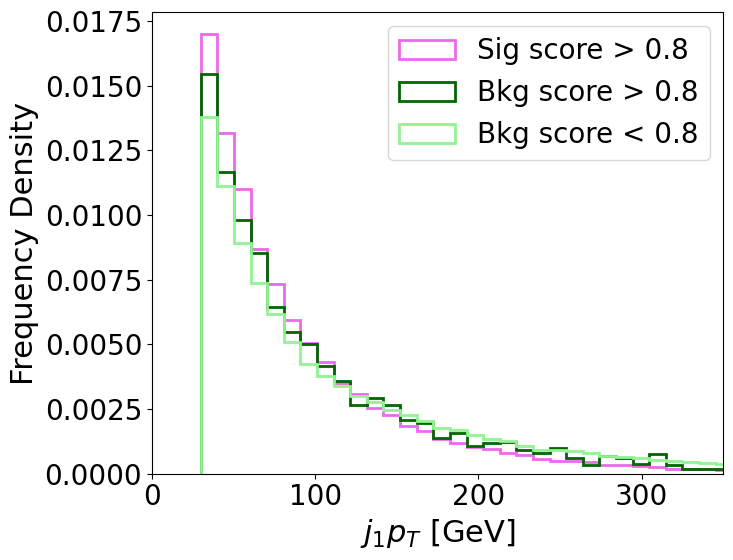

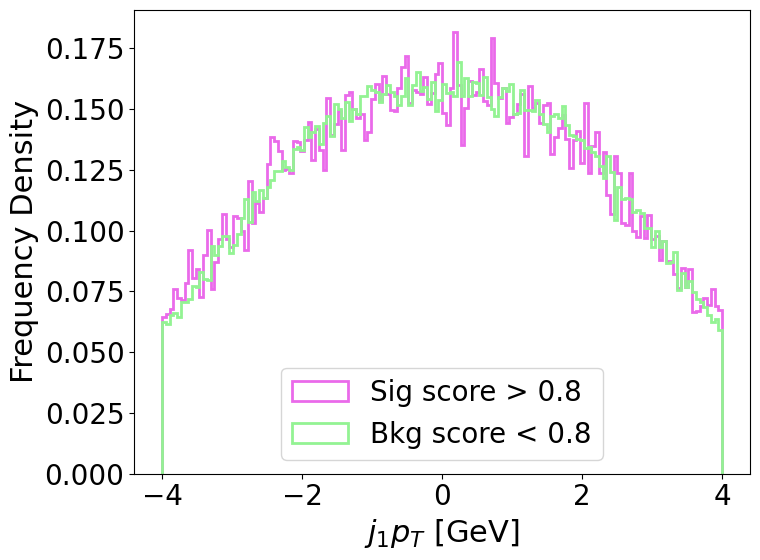

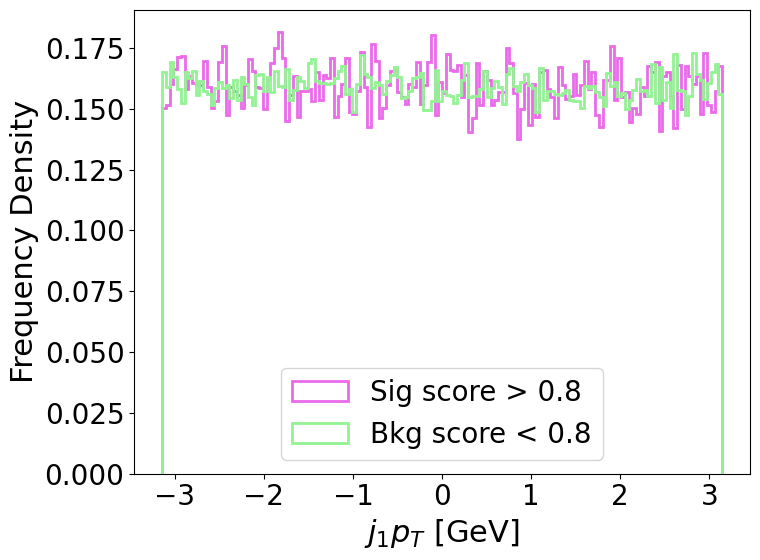

In [56]:
## jet1
# pT

a = [s[0] for s in jet1_greater_sig]
b = [s[0] for s in jet1_lesser_sig]
c = [s[0] for s in jet1_greater_bkg]
d = [s[0] for s in jet1_lesser_bkg]

plt.figure(figsize=(8, 6))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=200)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=100)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$j_1 p_T$ [GeV]')
plt.ylabel("Frequency Density")
plt.legend()
plt.xlim(0,350)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_j1pT_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_j1pT_{threshold1}.pdf')
plt.show()

# eta
a = [s[2] for s in jet1_greater_sig]
b = [s[2] for s in jet1_lesser_sig]
c = [s[2] for s in jet1_greater_bkg]
d = [s[2] for s in jet1_lesser_bkg]

plt.figure(figsize=(8, 6))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=200)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=150)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2, linestyle='--')
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$j_1 p_T$ [GeV]')
plt.ylabel("Frequency Density")
plt.legend()
#plt.xlim(0,350)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_j1eta_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_j1eta_{threshold1}.pdf')

# phi
a = [s[4] for s in jet1_greater_sig]
b = [s[4] for s in jet1_lesser_sig]
c = [s[4] for s in jet1_greater_bkg]
d = [s[4] for s in jet1_lesser_bkg]

plt.figure(figsize=(8, 6))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=200)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=150)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2, linestyle='--')
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$j_1 p_T$ [GeV]')
plt.ylabel("Frequency Density")
plt.legend()
#plt.xlim(0,350)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_j1phi_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_j1phi_{threshold1}.pdf')

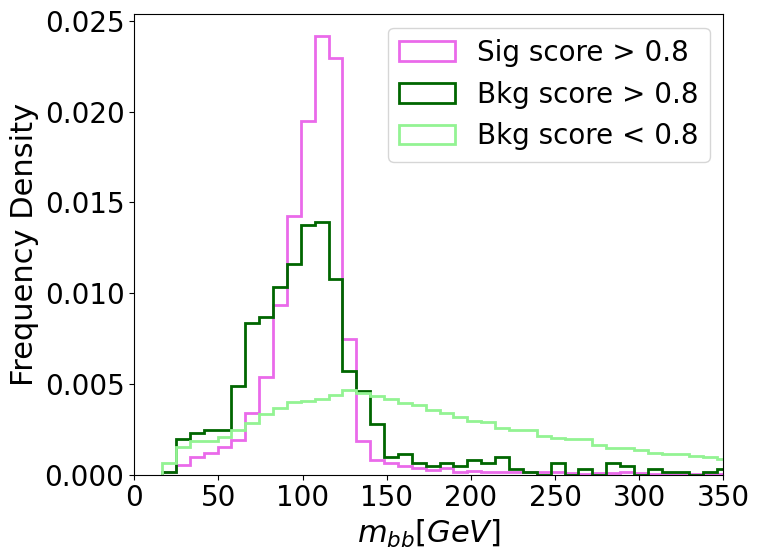

In [24]:
## m_bb

a = [s[6] for s in complex_greater_sig]
b = [s[6] for s in complex_lesser_sig]
c = [s[6] for s in complex_greater_bkg]
d = [s[6] for s in complex_lesser_bkg]


plt.figure(figsize=(8, 6))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=200)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=400)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$m_{bb} [GeV]$')
plt.ylabel("Frequency Density")
plt.legend()
plt.xlim(0,350)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_mbb_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_mbb_{threshold1}.pdf')
plt.show()

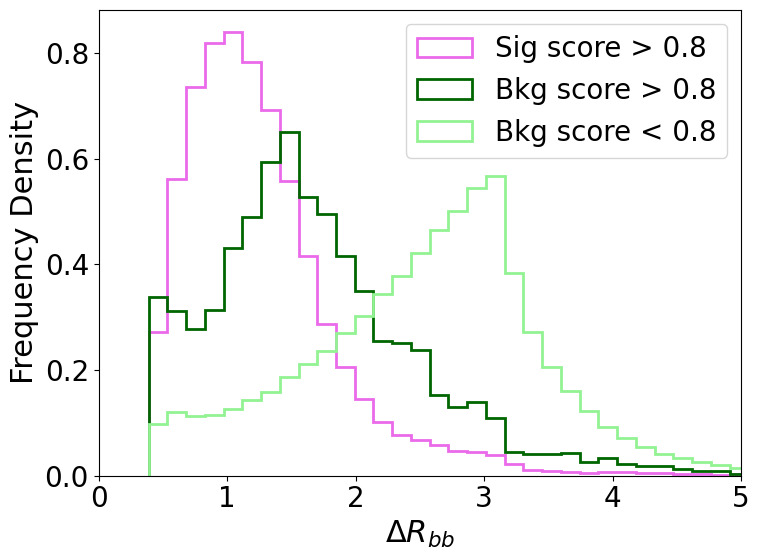

In [92]:
## dR_bb

a = [s[8] for s in complex_greater_sig]
b = [s[8] for s in complex_lesser_sig]
c = [s[8] for s in complex_greater_bkg]
d = [s[8] for s in complex_lesser_bkg]


plt.figure(figsize=(8, 6))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=50)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=50)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step')
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$\Delta R_{bb}$')
plt.ylabel("Frequency Density")
plt.legend()
plt.xlim(0,5)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_dRbb_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_dRbb_{threshold1}.pdf')
plt.show()

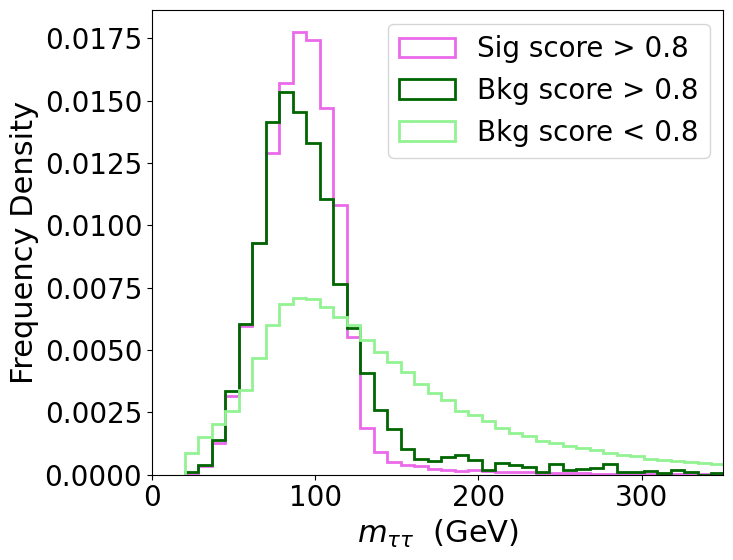

In [96]:
## m_tt

a = [s[10] for s in complex_greater_sig]
b = [s[10] for s in complex_lesser_sig]
c = [s[10] for s in complex_greater_bkg]
d = [s[10] for s in complex_lesser_bkg]


plt.figure(figsize=(8, 6))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=350)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=350)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step')
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$m_{\tau\tau}$  (GeV)')
plt.ylabel("Frequency Density")
plt.legend()
plt.xlim(0,350)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_mtt_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_mtt_{threshold1}.pdf')
plt.show()

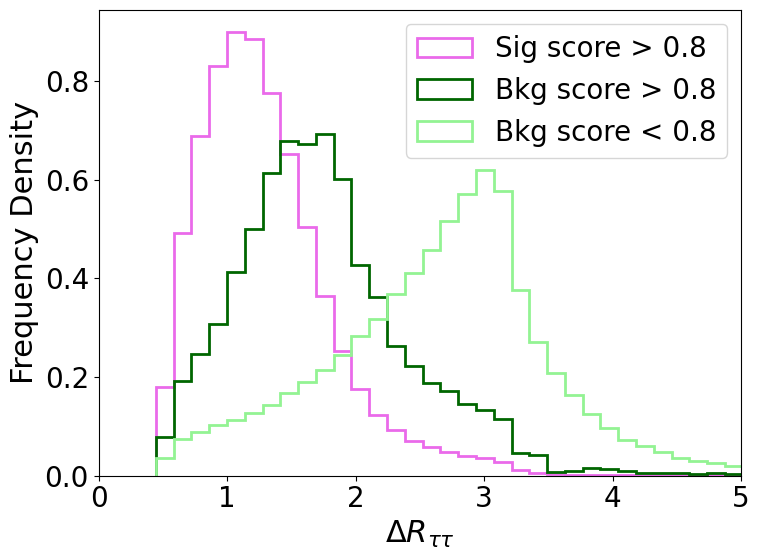

In [94]:
## dR_tt

a = [s[12] for s in complex_greater_sig]
b = [s[12] for s in complex_lesser_sig]
c = [s[12] for s in complex_greater_bkg]
d = [s[12] for s in complex_lesser_bkg]


plt.figure(figsize=(8, 6))
##bins=np.histogram(np.hstack((a,b,c,d)), bins=50)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=50)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step')
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$\Delta R_{\tau\tau}$')
plt.ylabel("Frequency Density")
plt.legend()
plt.xlim(0,5)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_dRtt_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_dRtt_{threshold1}.pdf')
plt.show()

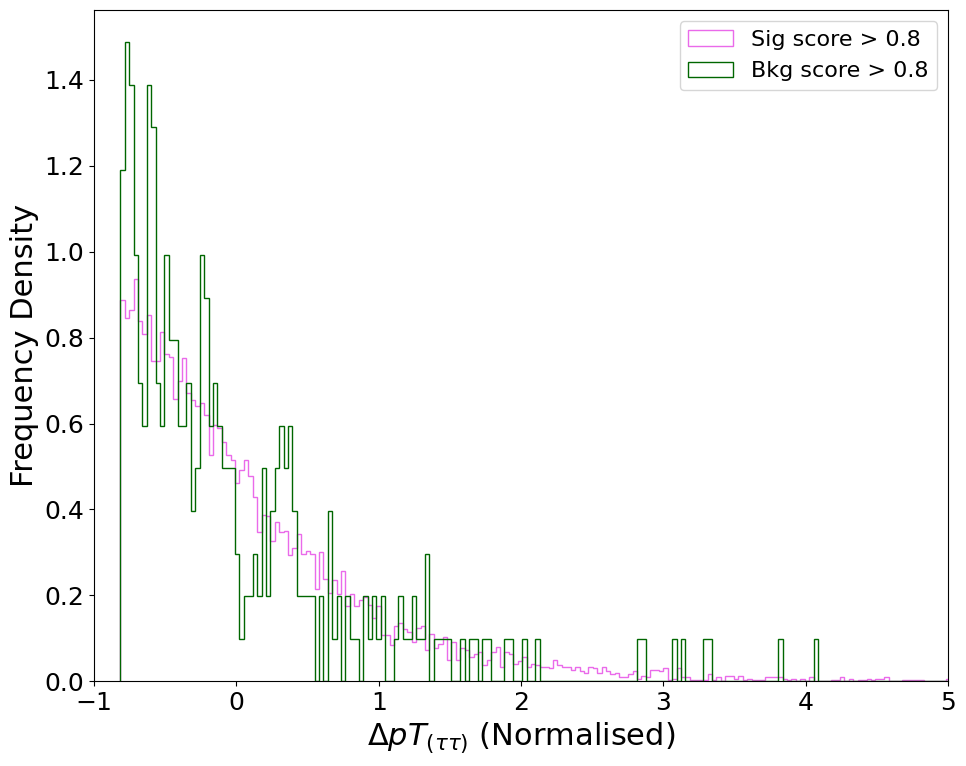

In [37]:
## dpT_tt

a = [s[14] for s in complex_greater_sig]
b = [s[14] for s in complex_lesser_sig]
c = [s[14] for s in complex_greater_bkg]
d = [s[14] for s in complex_lesser_bkg]


plt.figure(figsize=(10, 8))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=150)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=350)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step')
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step')
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step')
#plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step')
plt.xlabel(r'$\Delta pT_{(\tau\tau)}$ (Normalised)')
plt.ylabel("Frequency Density")
plt.legend()
plt.xlim(-1,5)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_dpTtt_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_dpTtt_{threshold1}.pdf')
plt.show()

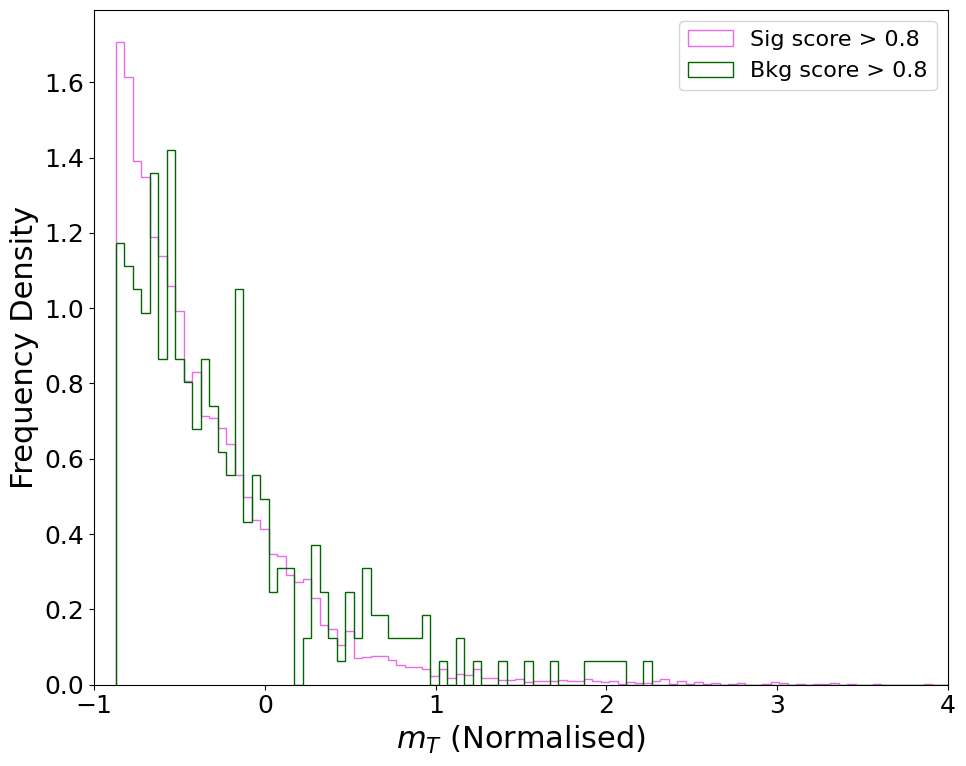

In [46]:
## dpT_tt

a = [s[16] for s in complex_greater_sig]
b = [s[16] for s in complex_lesser_sig]
c = [s[16] for s in complex_greater_bkg]
d = [s[16] for s in complex_lesser_bkg]


plt.figure(figsize=(10, 8))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=150)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=150)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step')
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step')
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step')
#plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step')
plt.xlabel(r'$m_T$ (Normalised)')
plt.ylabel("Frequency Density")
plt.legend()
plt.xlim(-1,4)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_mT_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_mT_{threshold1}.pdf')
plt.show()

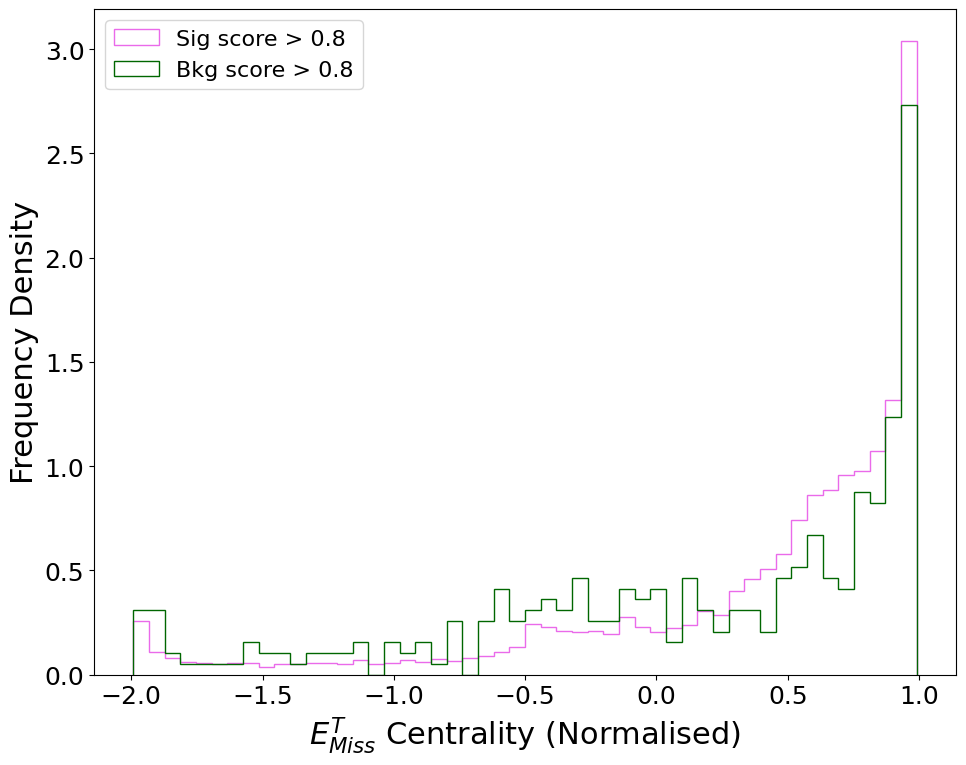

In [45]:
## C_met

a = [s[18] for s in complex_greater_sig]
b = [s[18] for s in complex_lesser_sig]
c = [s[18] for s in complex_greater_bkg]
d = [s[18] for s in complex_lesser_bkg]


plt.figure(figsize=(10, 8))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=50)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=50)[1]#
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step')
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step')
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step')
#plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step')
plt.xlabel(r'$E^T_{Miss}$ Centrality (Normalised)')
plt.ylabel("Frequency Density")
plt.legend()
#plt.xlim(-1,4)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_cMET_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_cMET_{threshold1}.pdf')
plt.show()

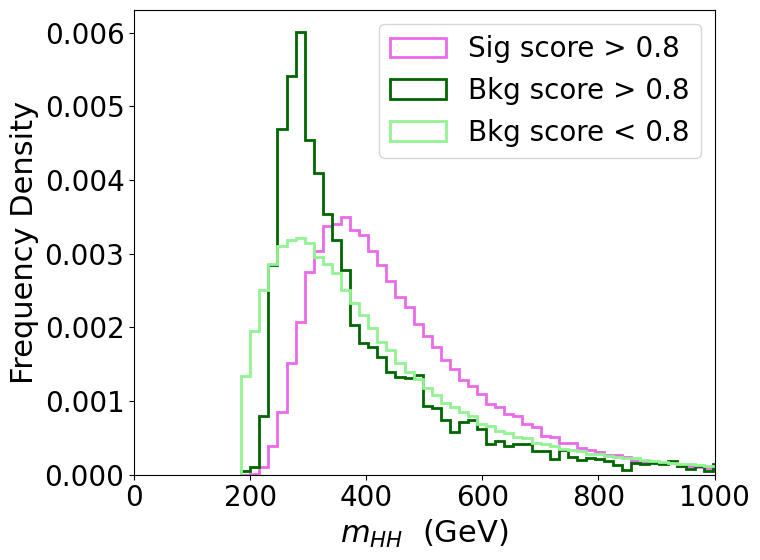

In [95]:
## m_HH

a = [s[20] for s in complex_greater_sig]
b = [s[20] for s in complex_lesser_sig]
c = [s[20] for s in complex_greater_bkg]
d = [s[20] for s in complex_lesser_bkg]


plt.figure(figsize=(8, 6))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=200)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=400)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step')
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$m_{HH}$  (GeV)')
plt.ylabel("Frequency Density")
plt.legend()
plt.xlim(0,1000)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_mHH_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_mHH_{threshold1}.pdf')
plt.show()

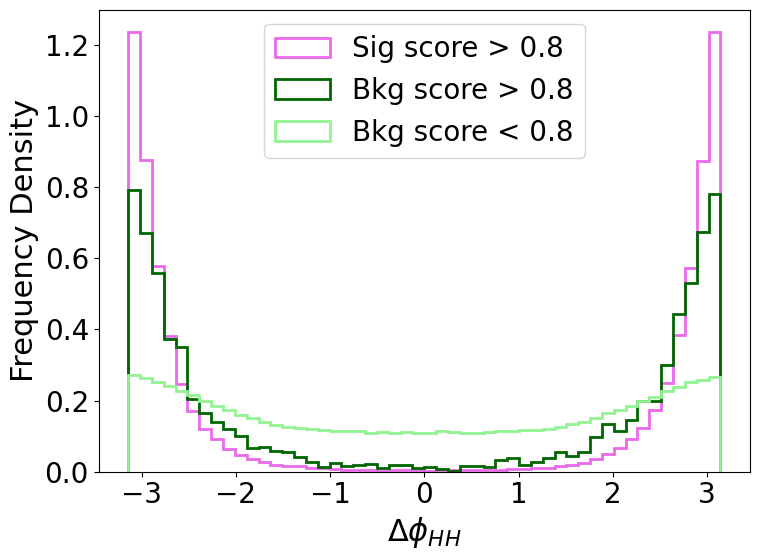

In [90]:
## dPhi_HH

a = [s[22] for s in complex_greater_sig]
b = [s[22] for s in complex_lesser_sig]
c = [s[22] for s in complex_greater_bkg]
d = [s[22] for s in complex_lesser_bkg]


plt.figure(figsize=(8, 6))
#bins=np.histogram(np.hstack((a,b,c,d)), bins=50)[1] #get the bin edges
bins=np.histogram(np.hstack((a,c)), bins=50)[1]
plt.hist(a, bins,color='#ea6aea',alpha = 1,label=f"Sig score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
#plt.hist(b, bins,color='deeppink',alpha = 1,label=f"Sig score < {threshold2}",density = True, histtype = 'step')
plt.hist(c, bins,color='#006600',alpha = 1,label=f"Bkg score > {threshold1}",density = True, histtype = 'step', linewidth = 2)
plt.hist(d, bins,color= '#93f393',alpha = 1,label=f"Bkg score < {threshold2}",density = True, histtype = 'step', linewidth = 2)
plt.xlabel(r'$\Delta \phi_{HH}$')
plt.ylabel("Frequency Density")
plt.legend()
#plt.xlim(-1.5,4)
plt.tight_layout()
plt.savefig(f'Saved Figures/Features by Score/VAR_dPhiHH_{threshold1}.png')
plt.savefig(f'Saved Figures/Features by Score/VAR_dPhiHH_{threshold1}.pdf')
plt.show()